# Spotify EDA
EDA Queries and Charts

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
import time

from sqlalchemy.ext.declarative import declarative_base 
from sqlalchemy import Table, Column, Integer, String, MetaData, and_, or_, func,distinct

%matplotlib inline

In [3]:
import importlib

sys.path.append('../')
from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator, pickle_load, pickle_save

In [4]:
# # Setup Pyton Variables in Markdown

# # https://github.com/ipython-contrib/jupyter_contrib_nbextensions
# !pip install jupyter_contrib_nbextensions

# # install javascript and css files
# !jupyter contrib nbextension install --user

# # There are many extensions available
# # https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/
# !jupyter nbextension enable python-markdown/main

# # NOTE: The notebook needs to be trusted!  See button on top-right of page

## Spotify API
You will need to setup a Spotify API developer account and store your credentials in local environment variables for these functions to work.

SPOTIFY_CLIENT_ID<br>
SPOTIFY_CLIENT_SECRET<br>
SPOTIFY_REDIRECT_URI<br>
<br>
template bash profile lines:<br>
export SPOTIFY_CLIENT_ID={your info here} <br>
export SPOTIFY_CLIENT_SECRET={your info here} <br>
export SPOTIFY_REDIRECT_URI=cs109arecommender://callback <br>

You will need to reload your bash profile and possibly restart your jupyter server.  


## SQL Lite DataBase

Provide path of static dataset database 

Get session from database module

Get the SQLalchemy Classes from session method

## Set database path on local drive

In [5]:
db_path = '../data/SpotifyDataSet/spotify_songs.db'

In [6]:
# Get sesion
session = get_session(db_path)

In [7]:
# Get Classes
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

### Test DB and Spotify Connections

In [8]:
# Spotify 
result = display_time(session.query(Tracks).first)
result.track_uri

Time to Execute: 0.03 seconds


'spotify:track:2d7LPtieXdIYzf7yHPooWd'

In [9]:
# Database
test_rv = display_time(session.query(Artists).first)
test_rv.artist_name

Time to Execute: 0.03 seconds


"Jane's Addiction with Body Count"

### Basic Counts

In [10]:

num_tracks        = display_time(session.query(Tracks).count)
num_artists       = display_time(session.query(Artists).count)
num_playlists     = display_time(session.query(Playlists.playlist_id).distinct().count)

print("Number of unique tracks in db:    {:,}".format(num_tracks))
print("Number of unique artists in db:   {:,}".format(num_artists))
print("Number of unique playlists in db: {:,}".format(num_playlists))

Time to Execute: 203.49 seconds
Time to Execute: 8.67 seconds
Time to Execute: 541.13 seconds
Number of unique tracks in db:    2,261,597
Number of unique artists in db:   296,014
Number of unique playlists in db: 999,001


### Playlists

In [11]:
# Count Number of tracks in playlists
songs_per_playlist = display_time(session.query(Playlists.playlist_id, 
                                func.count(Playlists.track_name).label('count')).group_by(Playlists.playlist_id).all)
# Do subsequent grouping in dataframe
df_counts = pd.DataFrame(data=songs_per_playlist, 
                         columns=["playlist_id","song_count"])

df_counts_agg = df_counts.groupby(['song_count']).agg({'playlist_id':'count'})

len(df_counts_agg)

Time to Execute: 383.68 seconds


309

In [12]:
print ("Mean number of songs per playlist  : {}".format(round(np.mean(df_counts.song_count), 2)))
print ("Median number of songs per playlist: {}".format(round(np.median(df_counts.song_count), 2)))

Mean number of songs per playlist  : 66.41
Median number of songs per playlist: 49.0


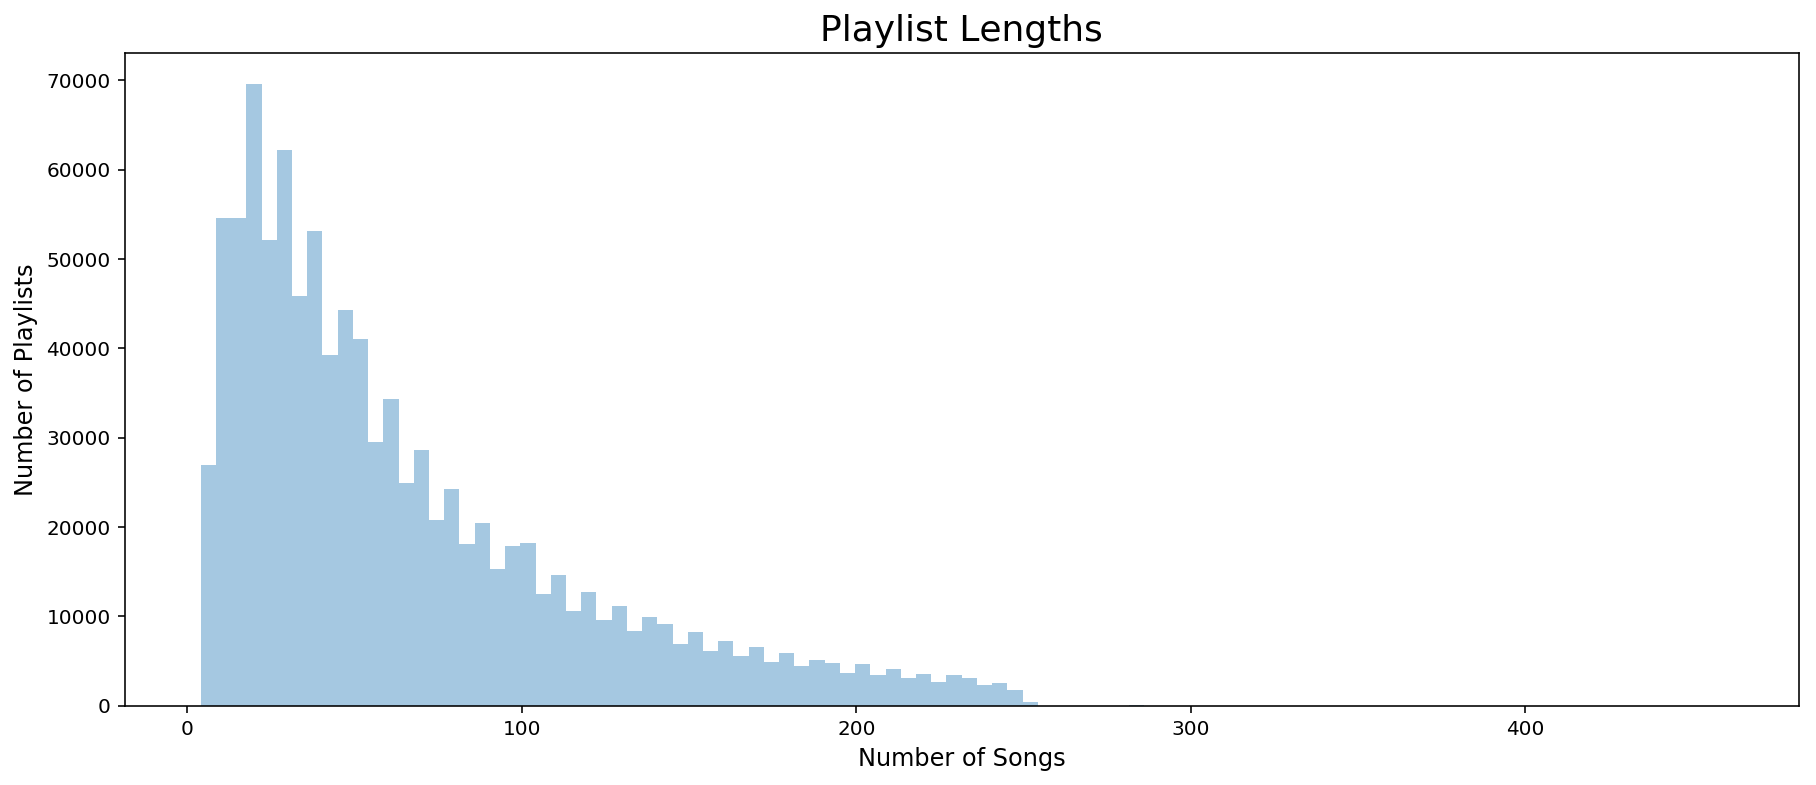

In [13]:
# Plot playlist length distribution
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Playlist Lengths", fontsize=18)
sns.distplot(df_counts.song_count, bins=100, ax=subplot, kde=False);
subplot.set_xlabel("Number of Songs", fontsize=12)
subplot.set_ylabel("Number of Playlists", fontsize=12);

## Artists

In [14]:
# Artist Popularity - measured by number of appearances
artist_playlist_count = display_time(session.query(Playlists.artist_name, func.count(Playlists.artist_name).label('count')).group_by(Playlists.artist_name).all)
df_artist_popularity = pd.DataFrame(artist_playlist_count).sort_values(by="count", ascending=False).reset_index(drop=True)
df_artist_popularity1 = df_artist_popularity.set_index(['artist_name'])

cols=['artist_name','count']
top20 = df_artist_popularity1[0:20]

Time to Execute: 430.23 seconds


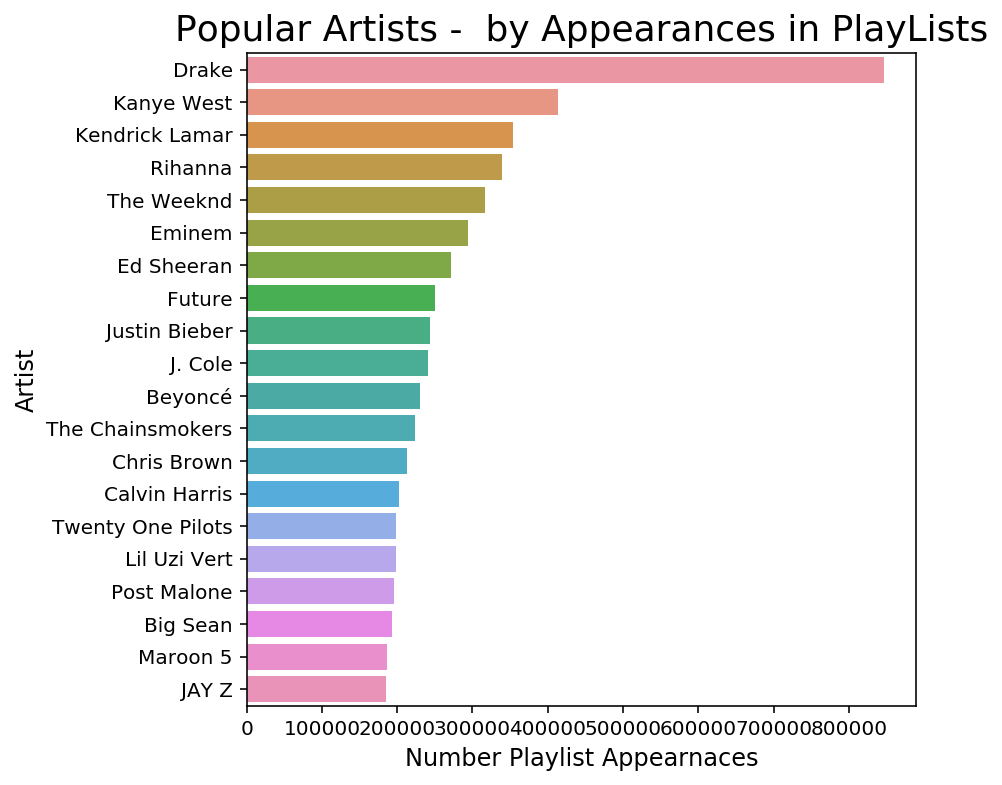

In [15]:
# Plot popular artists
fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Popular Artists -  by Appearances in PlayLists", fontsize=18)
sns.barplot(y=top20.index,
            x=top20['count'],
            orient="h", ax=subplot)
subplot.set_xlabel("Number Playlist Appearnaces", fontsize=12)
subplot.set_ylabel("Artist", fontsize=12);

Time to Execute: 4.67 seconds


TypeError: cannot perform reduce with flexible type

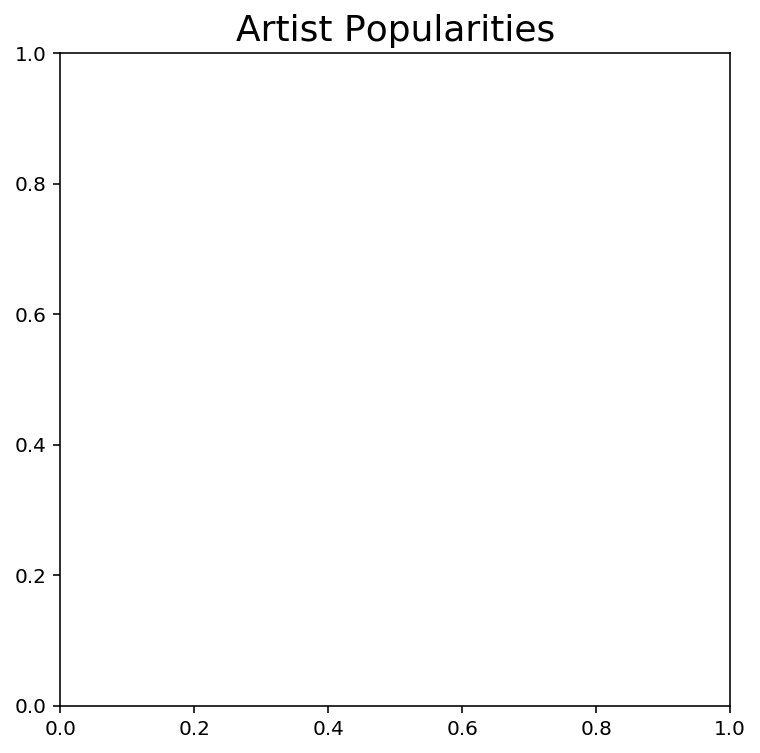

In [16]:
# Artist Popularity Values
artist_popularity = display_time(session.query(Artists.artist_name, Artists.artist_popularity).all)

fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Artist Popularities", fontsize=18)
sns.distplot(artist_popularity, ax=subplot)
subplot.set_xlabel("Popularity Value", fontsize=12)
subplot.set_ylabel("Count", fontsize=12);

### Artist Genres

In [ ]:
artist_genres = display_time(session.query(Artists.artist_name, Artists.genres).all)

### Tracks

In [ ]:
# get songs in a specified playlist into a df
rv = display_time(session.query(Playlists.track_name).filter(Playlists.playlist_id==101).all)
rv

In [ ]:
# get playlists that a specified song is in
rv = display_time(session.query(Playlists.playlist_id).filter(Tracks.track_name=="Who Says").all)
rv

### Spotify API

In [ ]:
# Get URI for Artist, Track and Album for a song
rv = display_time(session.query(Playlists.track_name, 
                                Playlists.track_uri,
                                Playlists.artist_uri,
                                Playlists.album_uri).filter(Playlists.track_name=="Who Says").distinct().first)

In [ ]:
rv

In [ ]:
# Get URI for Artist, Track and Album for a song
rv = display_time(session.query(Playlists).filter(Playlists.track_name=="Who Says").distinct().first)

In [ ]:
# use Spotify API to get artist genres from uri
get_spotify_data(db_uri=rv.artist_uri, key='genres')

In [ ]:
# use Spotify API to get artist popularity from uri
get_spotify_data(db_uri=rv.artist_uri, key='popularity')

In [ ]:
# use Spotify API to get track popularity from uri
get_spotify_data(db_uri=rv.track_uri, key='popularity')

### Get data using implicit Join between Songs and Audio_Features

In [ ]:
test_track = display_time(session.query(Playlists, Tracks)
                          .filter(Playlists.track_uri==Tracks.track_uri)
                          .distinct()
                          .first)

In [ ]:
for tk in test_track.keys():
    print (tk)
    tk_dict = test_track.__getattribute__(tk).__dict__
    for k,v in tk_dict.items():
        print ("\t{}  :  {}".format(k,v))

In [17]:
# get num playlists that a specified song is in
rv = display_time(session.query(Playlists.playlist_id).filter(Playlists.track_name=="Who Says").count)
rv

Time to Execute: 54.92 seconds


7474

In [255]:
# get number of unique artists
rv = display_time(session.query(Playlists.artist_name).distinct().count)
rv

2019-10-23 11:05:11,137 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT DISTINCT songs.artist_name AS songs_artist_name 
FROM songs) AS anon_1
2019-10-23 11:05:11,138 INFO sqlalchemy.engine.base.Engine ()
Time to Execute: 46.02 seconds


287740

In [257]:
# get all songs from a particular artist
rv = display_time(session.query(Playlists.track_name).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

2019-10-23 11:08:02,671 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT songs.track_name AS songs_track_name 
FROM songs 
WHERE songs.artist_name = ?
2019-10-23 11:08:02,672 INFO sqlalchemy.engine.base.Engine ('John Mayer',)
Time to Execute: 6.6 seconds


206

In [268]:
# get all playlists that an artist appears in
rv = display_time(session.query(Playlists.playlist_id).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

2019-10-23 11:14:48,562 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT songs.playlist_id AS songs_playlist_id 
FROM songs 
WHERE songs.artist_name = ?
2019-10-23 11:14:48,563 INFO sqlalchemy.engine.base.Engine ('John Mayer',)
Time to Execute: 6.87 seconds


48110

In [304]:
# get all songs in playlists where an artist appears in
subq = session.query(Playlists.playlist_id).filter(Playlists.artist_name=="John Mayer").distinct().subquery()
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Songs.track_name).filter(Playlists.playlist_id.in_(subq)).distinct().all)
len(rv)

Time to Execute: 81.7 seconds


4426419

In [305]:
# get all songs in playlists where a song appears in
subq = session.query(Playlists.playlist_id).filter(Playlists.track_name=="Who Says").distinct().subquery()
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Playlists.track_name).filter(Playlists.playlist_id.in_(subq)).distinct().all)
len(rv)

Time to Execute: 98.73 seconds


779527

In [309]:
rv[3]

(77, 'The Maine', 'Everything I Ask For')

In [264]:
# get all songs from playlists where an artist is in the list
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Playlists.track_name).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

(18, 'John Mayer', 'Stop This Train - Live at the Nokia Theatre')

## EDA

In [84]:
df_counts_agg[df_counts_agg.playlist_id==df_counts_agg.playlist_id.max()]

,playlist_id
song_count,
20,15028


In [93]:
# df_counts_agg.sort_values(by="playlist_id", ascending=False)
df_counts_agg[df_counts_agg.index<50].sum()

playlist_id    502676
dtype: int64

## Table and List Generators

In [11]:
# Table_Generator arguments:
#    query - an SqlAlchemy query e.g. session.query(Playlists)
#    batch_size  - default is 50

# This generator object will get a list of 50 artist records from the Artist table
# each time the batch_gen is iterated.
# When the table is exhausted, the generator will stop generating lists
table_session = get_session(db_path)
query = table_session.query(Artists)
table_batch_gen = Table_Generator(query=query, batch_size=50).batch_generator()

# calling the following will generate the next batch of records from the table
# each call to __next__() will get the next batch until the list is exhausted
# Here, we only show the first 5 items from the list...
table_batch_gen.__next__()[0:5]

# you can also iterate over the table_batch_gen object:
for batch in table_batch_gen:
    print("First batch size: {}".format(len(batch)))
    break
    
table_session.close()

Creating Table Generator:
	batch size :  50
	length     :  296014
	num batches:  5921


First batch size: 50


In [12]:
# List_Generator arguments
#    list - a list of items to iteratate over in batches
#    batch_size - defalt is 50
mylist = list(range(103))

list_batch_gen = List_Generator(mainlist=mylist, batch_size=50).batch_generator()

for i, batch in enumerate(list_batch_gen):
    print("Batch: {}  from:{}  to:{}".format(i, batch[0], batch[-1]))

Creating List Generator:
	batch size :  50
	length     :  103
	num batches:  3


Batch: 0  from:0  to:49
Batch: 1  from:50  to:99
Batch: 2  from:100  to:102


In [ ]:
connection.close()